<a href="https://colab.research.google.com/github/NahidurRahaman/Machine_Learning/blob/main/hybrid.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:

!pip install -q torch torchvision timm mlflow pyngrok pytorch-lightning==2.4.0
!pip install -q "huggingface-hub<1.0" "transformers<4.44" torchmetrics==1.4.0 scikit-learn numpy matplotlib seaborn


import os, shutil
if os.path.exists("/root/.cache/huggingface/hub"):
    shutil.rmtree("/root/.cache/huggingface/hub")


import os
import shutil
from pathlib import Path

from PIL import Image


import torch
from torch.utils.data import DataLoader

import pytorch_lightning as pl


from torchvision import datasets, transforms
import timm

import mlflow
import mlflow.pytorch

from pyngrok import ngrok

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.1/40.1 kB 2.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 815.2/815.2 kB 21.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.7/9.7 MB 44.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.8/2.8 MB 42.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 20.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 147.8/147.8 kB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.9/114.9 kB 6.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.0/85.0 kB 3.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.0/77.0 kB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 131.2/131.2 kB 7.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 983.2/983.2 kB 41.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 789.2/789.2 kB 32.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.3/

In [2]:

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Running on:", device)

Running on: cuda


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [10]:

NGROK_AUTH_TOKEN = "36CLviJ3eedsGnzgPHm7MM9g4De_4tDSxH3CgGEQCytxcXKgX"

MLRUNS_DIR = "/content/drive/MyDrive/Project-1/mlruns"
DATA_ZIP = "/content/drive/MyDrive/Project-1/archive.zip"


EXTRACT_DIR = "/content/drive/MyDrive/Project-1/RiceLeafsDisease"
IMG_SIZE = 224
BATCH_SIZE = 32
MAX_EPOCHS = 15

In [5]:
import os
import pytorch_lightning as pl
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

class PlantDataModule(pl.LightningDataModule):

    def __init__(self, data_dir, batch_size=32, img_size=224):

        super().__init__()
        self.data_dir = data_dir
        self.batch_size = batch_size
        self.img_size = img_size


        self.train_tfms = transforms.Compose([
            transforms.Resize((img_size, img_size)),
            transforms.RandomHorizontalFlip(),
            transforms.ToTensor()
        ])


        self.val_tfms = transforms.Compose([
            transforms.Resize((img_size, img_size)),
            transforms.ToTensor()
        ])


    def setup(self, stage=None):

        train_dir = os.path.join(self.data_dir, "train")
        val_dir = os.path.join(self.data_dir, "validation")
        test_dir = os.path.join(self.data_dir, "validation")

        if not os.path.exists(train_dir):
            raise FileNotFoundError(f"Expected train folder at {train_dir}")


        self.train_ds = datasets.ImageFolder(train_dir, transform=self.train_tfms)
        self.val_ds = datasets.ImageFolder(val_dir, transform=self.val_tfms) if os.path.exists(val_dir) else None
        self.test_ds = datasets.ImageFolder(test_dir, transform=self.val_tfms) if os.path.exists(test_dir) else None


    def train_dataloader(self):
        return DataLoader(
            self.train_ds,
            batch_size=self.batch_size,
            shuffle=True,
            num_workers=2
        )

    def val_dataloader(self):
        return DataLoader(
            self.val_ds,
            batch_size=self.batch_size,
            num_workers=2
        ) if self.val_ds else None


    def test_dataloader(self):
        return DataLoader(
            self.test_ds,
            batch_size=self.batch_size,
            num_workers=2
        ) if self.test_ds else None

In [35]:
import torch
import torch.nn as nn
import pytorch_lightning as pl
import timm
from torch.optim import AdamW
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torchmetrics import Accuracy


class TomatoHybridModel(pl.LightningModule):
    def __init__(self, num_classes=6, lr=1e-4, weight_decay=1e-5):
        super().__init__()
        self.save_hyperparameters()

        self.swin = timm.create_model(
            "swin_tiny_patch4_window7_224",
            pretrained=True,
            features_only=True,
            out_indices=[3]
        )

        self.vit = timm.create_model(
            "vit_base_patch16_224",
            pretrained=True,
            num_classes=0
        )

        self.efficientnet = timm.create_model(
            "efficientnetv2_rw_s",
            pretrained=True,
            num_classes=0
        )


        self.fusion = nn.Sequential(
            nn.LazyLinear(1024),
            nn.BatchNorm1d(1024),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(1024, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(512, num_classes)
        )


        self.criterion = nn.CrossEntropyLoss(label_smoothing=0.1)
        self.train_acc = Accuracy(task="multiclass", num_classes=num_classes)
        self.val_acc   = Accuracy(task="multiclass", num_classes=num_classes)


        self.train_acc_history = []
        self.val_acc_history = []
        self.train_loss_history = []
        self.val_loss_history = []

    def forward(self, x):
        swin_feat = self.swin(x)[-1].mean([2, 3])
        vit_feat  = self.vit(x)
        eff_feat  = self.efficientnet(x)
        if eff_feat.dim() == 4:
            eff_feat = eff_feat.mean([2, 3])

        fused = torch.cat([swin_feat, vit_feat, eff_feat], dim=1)
        return self.fusion(fused)

    def training_step(self, batch, _):
        x, y = batch
        logits = self(x)
        loss = self.criterion(logits, y)
        acc = self.train_acc(logits, y)

        self.log("train_loss", loss, prog_bar=True)
        self.log("train_acc", acc, prog_bar=True)

        return loss

    def validation_step(self, batch, _):
        x, y = batch
        logits = self(x)
        loss = self.criterion(logits, y)
        acc = self.val_acc(logits, y)

        self.log("val_loss", loss, prog_bar=True)
        self.log("val_acc", acc, prog_bar=True)


    def on_train_epoch_end(self):
        self.train_acc_history.append(self.train_acc.compute().item())
        self.train_loss_history.append(
            self.trainer.callback_metrics["train_loss"].item()
        )
        self.train_acc.reset()

    def on_validation_epoch_end(self):
        self.val_acc_history.append(self.val_acc.compute().item())
        self.val_loss_history.append(
            self.trainer.callback_metrics["val_loss"].item()
        )
        self.val_acc.reset()

    def configure_optimizers(self):
        optimizer = AdamW(
            self.parameters(),
            lr=self.hparams.lr,
            weight_decay=self.hparams.weight_decay
        )
        scheduler = ReduceLROnPlateau(
            optimizer, mode="min", patience=3, factor=0.5
        )
        return {
            "optimizer": optimizer,
            "lr_scheduler": {"scheduler": scheduler, "monitor": "val_loss"}
        }

In [36]:
from pytorch_lightning.callbacks import EarlyStopping, ModelCheckpoint

early_stop = EarlyStopping(
    monitor="val_loss",
    patience=5,
    min_delta=0.001,
    mode="min",
    verbose=True
)

In [44]:
from pytorch_lightning.callbacks import ModelCheckpoint

checkpoint_callback = ModelCheckpoint(
    monitor="val_loss",
    dirpath="/content/drive/MyDrive/Project-1/checkpoints",
    filename="best_model",
    save_top_k=1,
    mode="min",
    verbose=True
)


In [45]:
dm = PlantDataModule(EXTRACT_DIR, batch_size=BATCH_SIZE, img_size=224)

try:
    dm.setup()
except Exception as e:
    raise RuntimeError(f"Data setup failed: {e}")

num_classes = len(dm.train_ds.classes)
print("Classes:", dm.train_ds.classes)

Classes: ['bacterial_leaf_blight', 'brown_spot', 'healthy', 'leaf_blast', 'leaf_scald', 'narrow_brown_spot']


In [46]:
print("Preparing data module and model (this will error if your dataset path is wrong)...")
dm = PlantDataModule(EXTRACT_DIR, batch_size=BATCH_SIZE, img_size=224)

try:
    dm.setup()
except Exception as e:
    raise RuntimeError(f"Data setup failed: {e}")

num_classes = len(dm.train_ds.classes)
print("Classes:", dm.train_ds.classes)

model = TomatoHybridModel(num_classes=num_classes)

Preparing data module and model (this will error if your dataset path is wrong)...
Classes: ['bacterial_leaf_blight', 'brown_spot', 'healthy', 'leaf_blast', 'leaf_scald', 'narrow_brown_spot']


In [48]:
checkpoints = os.path.join(
    os.getcwd(), "checkpoints", "/content/drive/MyDrive/Project-1/best_model.pth"
)

In [49]:
if os.path.exists(checkpoints):
    model.load_state_dict(torch.load(checkpoints))
    print("Model loaded successfully from checkpoints.")

Model loaded successfully from checkpoints.


In [50]:
trainer = pl.Trainer(
    max_epochs=15,
)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


In [51]:
trainer.fit(model, dm)

INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name         | Type               | Params | Mode 
------------------------------------------------------------
0 | swin         | FeatureListNet     | 27.5 M | train
1 | vit          | VisionTransformer  | 85.8 M | train
2 | efficientnet | EfficientNet       | 22.1 M | train
3 | fusion       | Sequential         | 3.2 M  | train
4 | criterion    | CrossEntropyLoss   | 0      | train
5 | train_acc    | MulticlassAccuracy | 0      | train
6 | val_acc      | MulticlassAccuracy | 0      | train
------------------------------------------------------------
138 M     Trainable params
0         Non-trainable params
138 M     Total params
554.501   Total estimated model params size (MB)
1267      Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=15` reached.


In [93]:

MODEL_PATH = "/content/drive/MyDrive/Project-1/best_model.pth"
torch.save(model.state_dict(), MODEL_PATH)
print("Model saved at:", MODEL_PATH)

num_classes = len(dm.train_ds.classes)
num_classes

Model saved at: /content/drive/MyDrive/Project-1/best_model.pth


6

In [78]:
trainer.validate(model, dm)

INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Validation: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│          val_acc          │    0.9734848737716675     │
│         val_loss          │    0.47827860713005066    │
└───────────────────────────┴───────────────────────────┘

[{'val_loss': 0.47827860713005066, 'val_acc': 0.9734848737716675}]

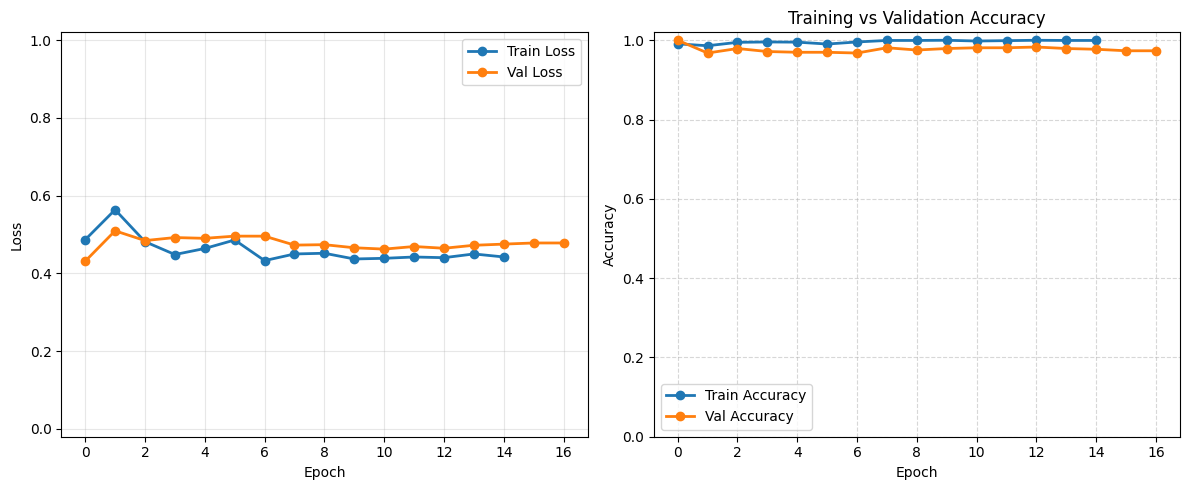

In [85]:
import matplotlib.pyplot as plt
plt.figure(figsize=(12, 5))
max_loss = max(model.train_loss_history + model.val_loss_history)
max_acc = max(model.train_acc_history + model.val_acc_history)

plt.subplot(1, 2, 1)
plt.plot(model.train_loss_history,marker='o', linewidth=2, label="Train Loss")
plt.plot(model.val_loss_history,   marker='o', linewidth=2, label="Val Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.ylim(-0.02, 1.02)
plt.legend()
plt.grid(alpha=0.3)

plt.subplot(1, 2, 2)
plt.plot(model.train_acc_history, marker='o', linewidth=2, label="Train Accuracy")
plt.plot(model.val_acc_history,   marker='o', linewidth=2, label="Val Accuracy")
plt.ylim(0, 1.02)
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Training vs Validation Accuracy")
plt.legend()
plt.grid(True, linestyle="--", alpha=0.5)


plt.tight_layout()
plt.show()

<Figure size 1000x800 with 0 Axes>

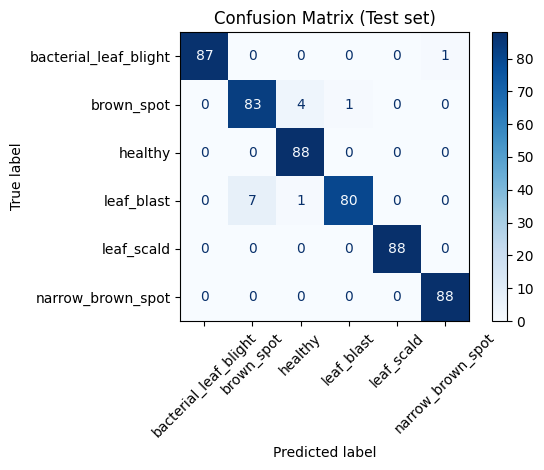

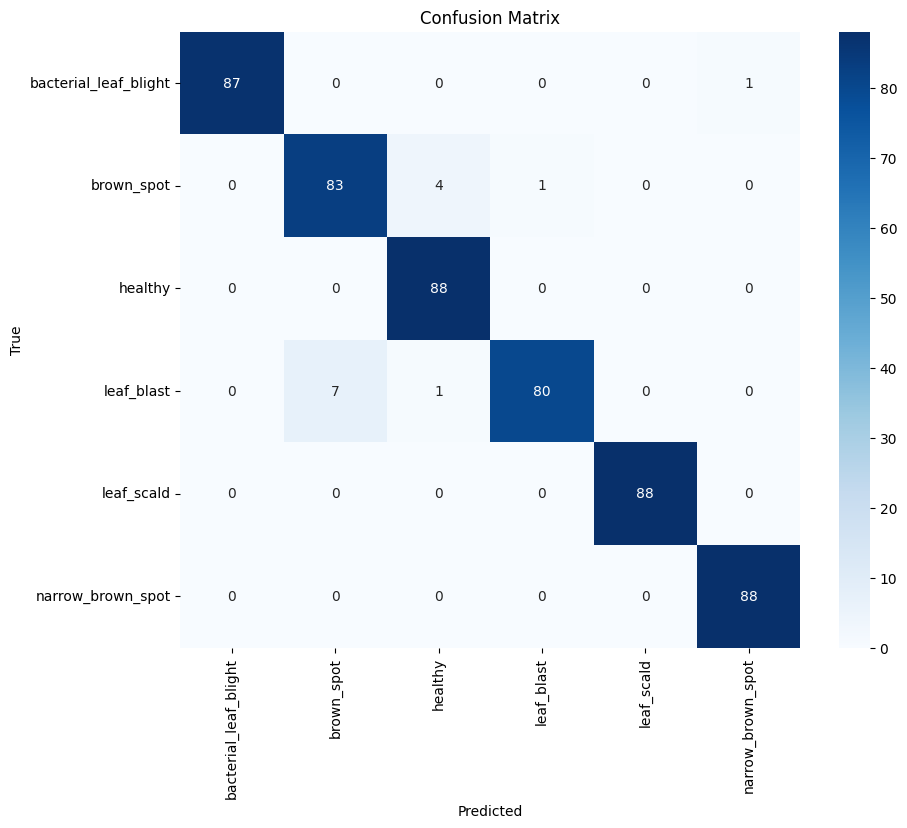

In [62]:
import torch
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import seaborn as sns
import matplotlib.pyplot as plt

model.eval()
model.to('cuda' if torch.cuda.is_available() else 'cpu')

all_preds = []
all_labels = []

test_dl = dm.test_dataloader()
if test_dl is None:
    print("No test set found → using validation set")
    test_dl = dm.val_dataloader()

with torch.no_grad():
    for batch in test_dl:
        x, y = batch
        x = x.to(model.device)
        logits = model(x)
        preds = logits.argmax(dim=1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(y.cpu().numpy())
cm = confusion_matrix(all_labels, all_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=dm.train_ds.classes)

plt.figure(figsize=(10, 8))
disp.plot(cmap='Blues', xticks_rotation=45)
plt.title("Confusion Matrix (Test set)")
plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=dm.train_ds.classes,
            yticklabels=dm.train_ds.classes)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

In [30]:
!pip install grad-cam

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 73.5 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for grad-cam: filename=grad_cam-1.5.5-py3-none-any.whl size=44284 sha256=52c6c0fcf6b5ebb89d49d7fb7610b53e6950575a01cbf2eaa91ad9a3aa099471
  Stored in directory: /root/.cache/pip/wheels/fb/3b/09/2afc520f3d69bc26ae6bd87416759c820a3f7d05c1a077bbf6
Successfully built grad-cam


In [33]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc

In [60]:
import numpy as np
import torch
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc

model.eval()
model_device = next(model.parameters()).device
model.to(model_device)

all_labels = []
all_logits = []


current_dataloader = dm.test_dataloader()
if current_dataloader is None:
    print("No test set found, using validation set for ROC curve calculation.")
    current_dataloader = dm.val_dataloader()
    if current_dataloader is None:
        raise ValueError("Neither validation nor test dataloader is available. Cannot compute ROC curve.")
else:
    print("Using test set for ROC curve calculation.")

with torch.no_grad():
    for inputs, targets in current_dataloader:
        inputs = inputs.to(model_device)
        logits = model(inputs)
        all_logits.append(logits.cpu())
        all_labels.append(targets.cpu())


all_logits = torch.cat(all_logits).numpy()
all_labels = torch.cat(all_labels).numpy()


num_classes = len(dm.train_ds.classes)
class_names = dm.train_ds.classes


y_true = label_binarize(all_labels, classes=list(range(num_classes)))

y_score = torch.softmax(torch.tensor(all_logits), dim=1).numpy()

print(f"Collected {len(all_labels)} samples for ROC analysis.")
print(f"Shape of y_true: {y_true.shape}")
print(f"Shape of y_score: {y_score.shape}")


Using test set for ROC curve calculation.
Collected 528 samples for ROC analysis.
Shape of y_true: (528, 6)
Shape of y_score: (528, 6)


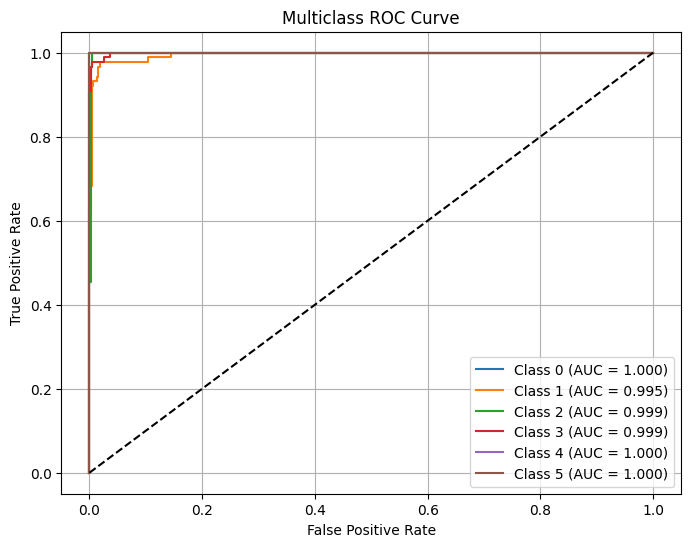

In [61]:
plt.figure(figsize=(8, 6))

for i in range(num_classes):
    fpr, tpr, _ = roc_curve(y_true[:, i], y_score[:, i])
    roc_auc = auc(fpr, tpr)

    plt.plot(
        fpr,
        tpr,
        label=f"Class {i} (AUC = {roc_auc:.3f})"
    )

plt.plot([0, 1], [0, 1], "k--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Multiclass ROC Curve")
plt.legend(loc="lower right")
plt.grid(True)
plt.show()


Classification Report (Precision, Recall, F1-Score)
                       precision    recall  f1-score   support

bacterial_leaf_blight     1.0000    0.9886    0.9943        88
           brown_spot     0.9222    0.9432    0.9326        88
              healthy     0.9462    1.0000    0.9724        88
           leaf_blast     0.9877    0.9091    0.9467        88
           leaf_scald     1.0000    1.0000    1.0000        88
    narrow_brown_spot     0.9888    1.0000    0.9944        88

             accuracy                         0.9735       528
            macro avg     0.9741    0.9735    0.9734       528
         weighted avg     0.9741    0.9735    0.9734       528



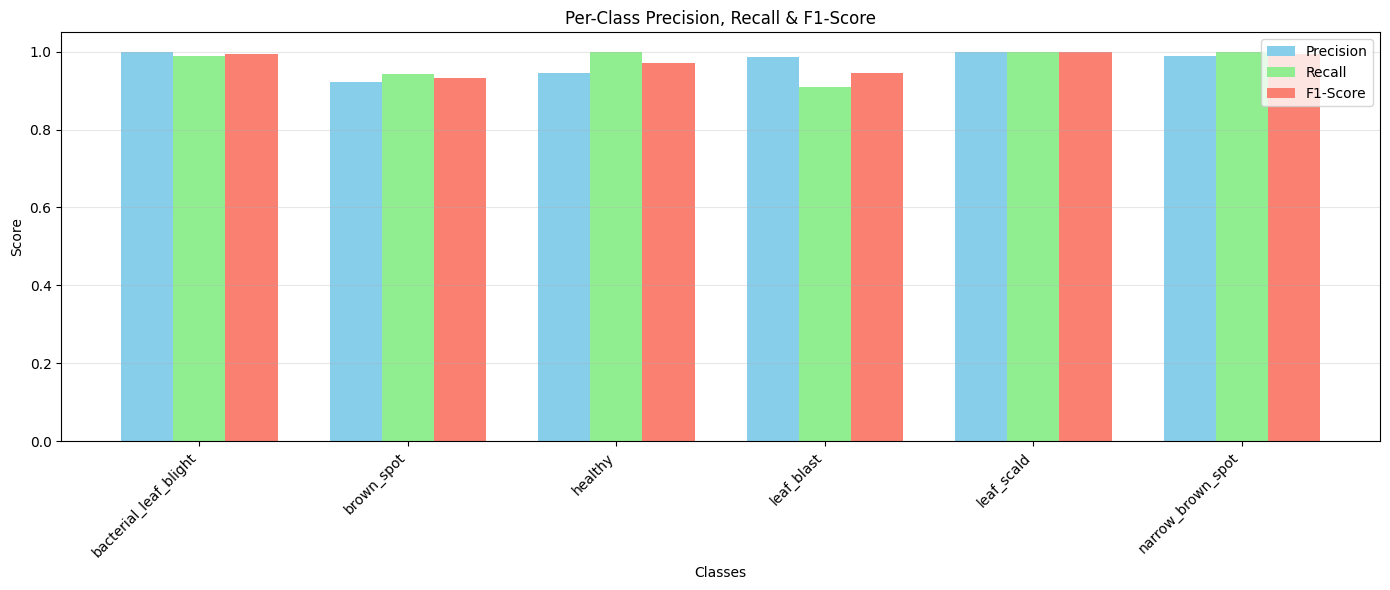

<Figure size 1200x1000 with 0 Axes>

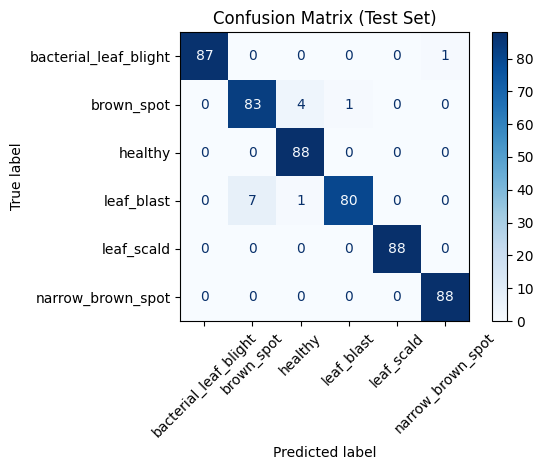


Summary Averages
Macro Average    → Precision: 0.9741 | Recall: 0.9735 | F1: 0.9734
Weighted Average → Precision: 0.9741 | Recall: 0.9735 | F1: 0.9734


In [86]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, precision_recall_fscore_support
import torch

model.eval()
all_preds = []
all_labels = []
all_probs = []  # optional for ROC if needed later

test_dl = dm.test_dataloader()  # or dm.val_dataloader() if no test set

with torch.no_grad():
    for batch in test_dl:
        x, y = batch
        x = x.to(model.device)
        logits = model(x)
        probs = torch.softmax(logits, dim=1).cpu().numpy()
        preds = logits.argmax(dim=1).cpu().numpy()

        all_preds.extend(preds)
        all_labels.extend(y.cpu().numpy())
        all_probs.extend(probs)


all_preds = np.array(all_preds)
all_labels = np.array(all_labels)
all_probs = np.array(all_probs)

class_names = dm.train_ds.classes

print("\n" + "="*60)
print("Classification Report (Precision, Recall, F1-Score)")
print("="*60)
report = classification_report(all_labels, all_preds, target_names=class_names, digits=4)
print(report)

precision, recall, f1, support = precision_recall_fscore_support(all_labels, all_preds, average=None)

plt.figure(figsize=(14, 6))
x = np.arange(len(class_names))
width = 0.25

plt.bar(x - width, precision, width, label='Precision', color='skyblue')
plt.bar(x, recall, width, label='Recall', color='lightgreen')
plt.bar(x + width, f1, width, label='F1-Score', color='salmon')

plt.xlabel('Classes')
plt.ylabel('Score')
plt.title('Per-Class Precision, Recall & F1-Score')
plt.xticks(x, class_names, rotation=45, ha='right')
plt.legend()
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

cm = confusion_matrix(all_labels, all_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)

plt.figure(figsize=(12, 10))
disp.plot(cmap='Blues', xticks_rotation=45)
plt.title("Confusion Matrix (Test Set)")
plt.tight_layout()
plt.show()

precision_macro, recall_macro, f1_macro, _ = precision_recall_fscore_support(all_labels, all_preds, average='macro')
precision_weighted, recall_weighted, f1_weighted, _ = precision_recall_fscore_support(all_labels, all_preds, average='weighted')

print("\n" + "="*60)
print("Summary Averages")
print("="*60)
print(f"Macro Average    → Precision: {precision_macro:.4f} | Recall: {recall_macro:.4f} | F1: {f1_macro:.4f}")
print(f"Weighted Average → Precision: {precision_weighted:.4f} | Recall: {recall_weighted:.4f} | F1: {f1_weighted:.4f}")

In [140]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

from pytorch_grad_cam import GradCAM, ScoreCAM
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam.utils.image import show_cam_on_image

In [148]:
def vit_swin_reshape_transform(tensor):
    # If the input is a list (e.g., from FeatureListNet with features_only=True)
    # extract the actual tensor from it.
    if isinstance(tensor, list):
        tensor = tensor[0] # Assuming it's a list with a single tensor from out_indices=[3]

    if tensor.ndim == 4: # Swin FeatureListNet output (B, C, H_spatial, W_spatial)
        # This is already in (B, C, H, W) format, which ScoreCAM's upsampling expects.
        return tensor

    elif tensor.ndim == 3: # ViT tokens output (B, N, C)
        B, N, C = tensor.shape
        # Infer spatial dimensions (H, W) from N
        # N could be 1 + H*W (with CLS token) or H*W (without CLS token)

        H = W = 0
        # Try to infer H, W assuming N is H*W or 1+H*W
        if int(N**0.5) * int(N**0.5) == N: # N is a perfect square, assume no CLS token
            H = W = int(N**0.5)
            # Reshape from (B, N, C) to (B, C, H, W)
            return tensor.permute(0, 2, 1).reshape(B, C, H, W)
        elif N > 1 and int((N-1)**0.5) * int((N-1)**0.5) == (N-1): # N-1 is a perfect square, assume CLS token
            H = W = int((N - 1)**0.5)
            # Remove CLS token, then reshape from (B, N-1, C) to (B, C, H, W)
            return tensor[:, 1:, :].permute(0, 2, 1).reshape(B, C, H, W)
        else:
            raise ValueError(f"Cannot infer 2D spatial dimensions from 3D tensor with N={N}. Shape: {tensor.shape}")
    else:
        raise ValueError(f"Unexpected tensor dimensions for reshape_transform: {tensor.ndim}. Shape: {tensor.shape}")

In [149]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.eval()

# ─── Swin CAM (Score-CAM) ───
swin_cam = ScoreCAM(
    model=model,
    target_layers=[model.swin],
    reshape_transform=vit_swin_reshape_transform
    # Removed 'batch_size' argument
)

# ─── ViT CAM (Score-CAM) ───
vit_cam = ScoreCAM(
    model=model,
    target_layers=[model.vit.blocks[-1].norm1],
    reshape_transform=vit_swin_reshape_transform
    # Removed 'batch_size' argument
)

# ─── EfficientNet CAM (Grad-CAM) ───
eff_cam = GradCAM(
    model=model,
    target_layers=[model.efficientnet.blocks[-1]]
)

100%|██████████| 48/48 [00:15<00:00,  3.19it/s]


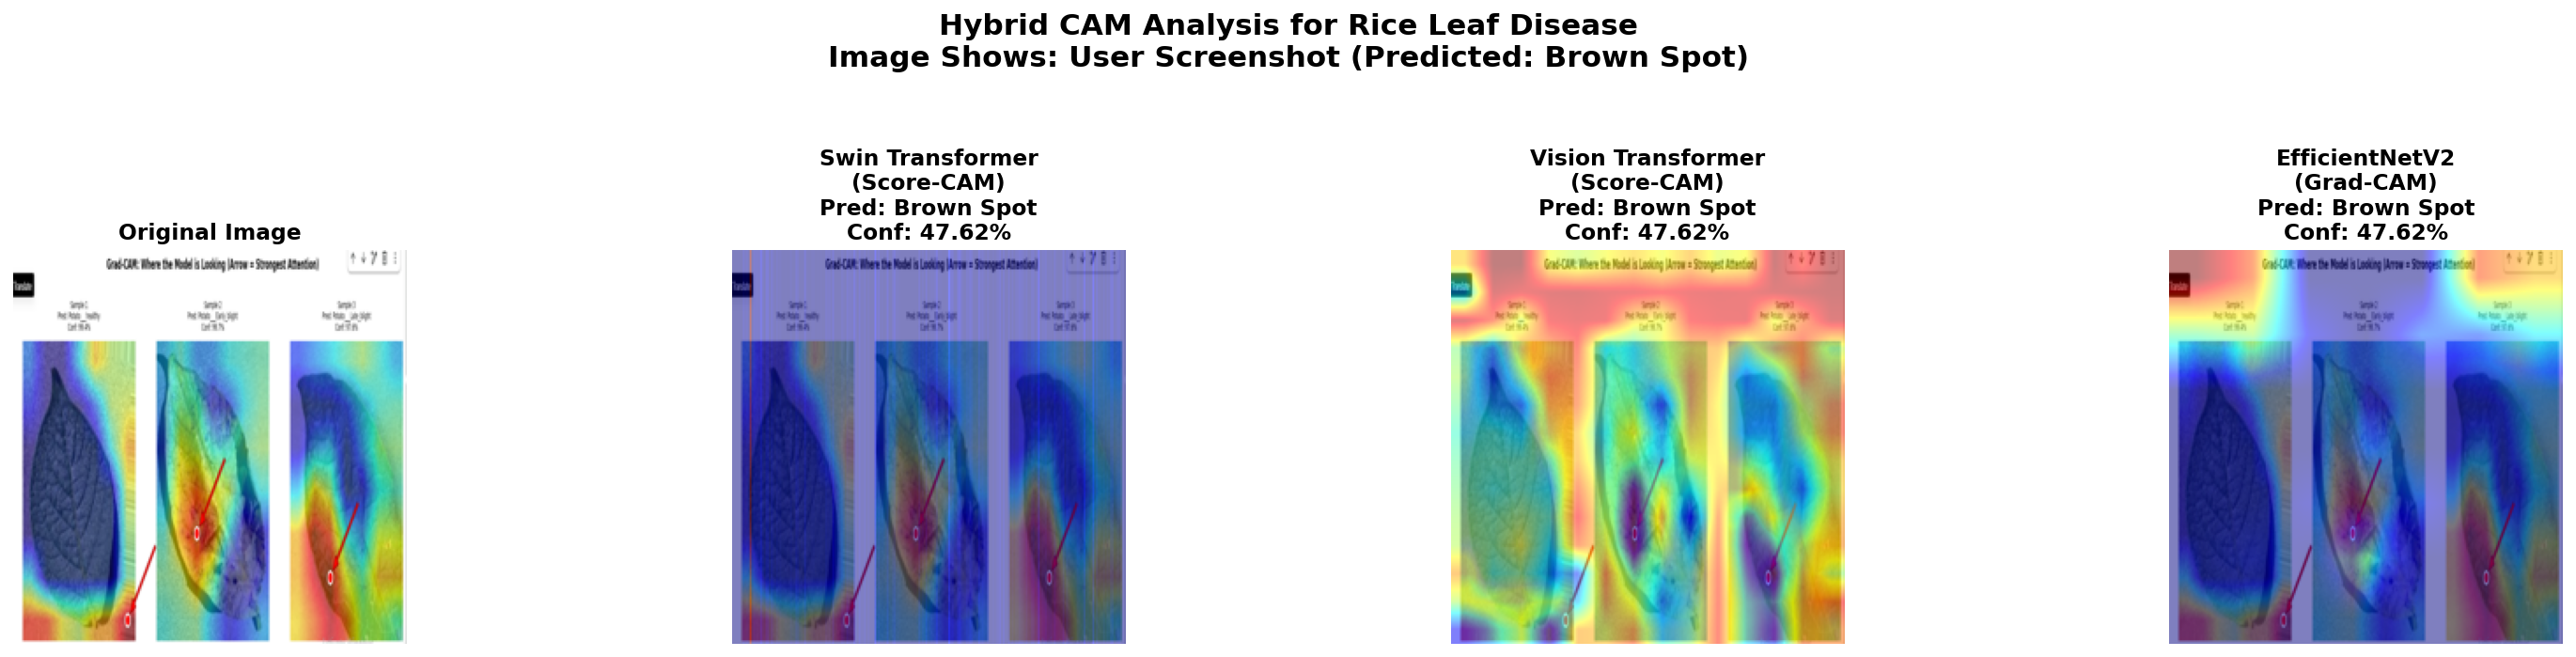

100%|██████████| 48/48 [00:15<00:00,  3.02it/s]


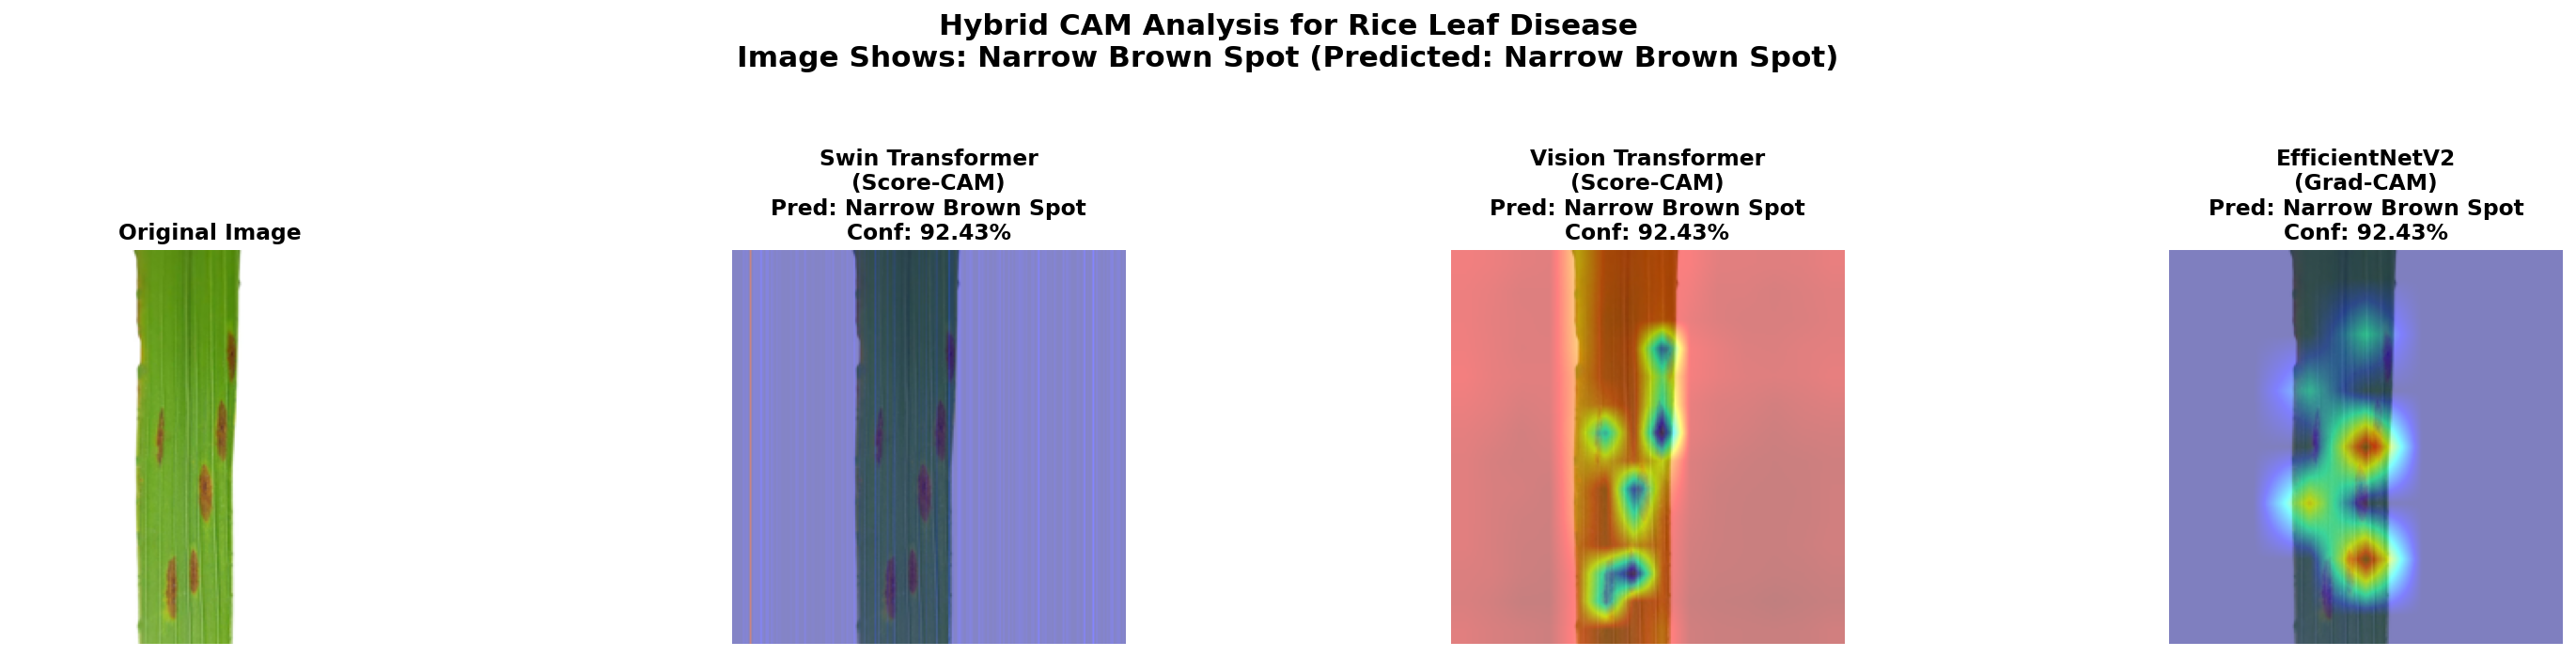

100%|██████████| 48/48 [00:15<00:00,  3.16it/s]


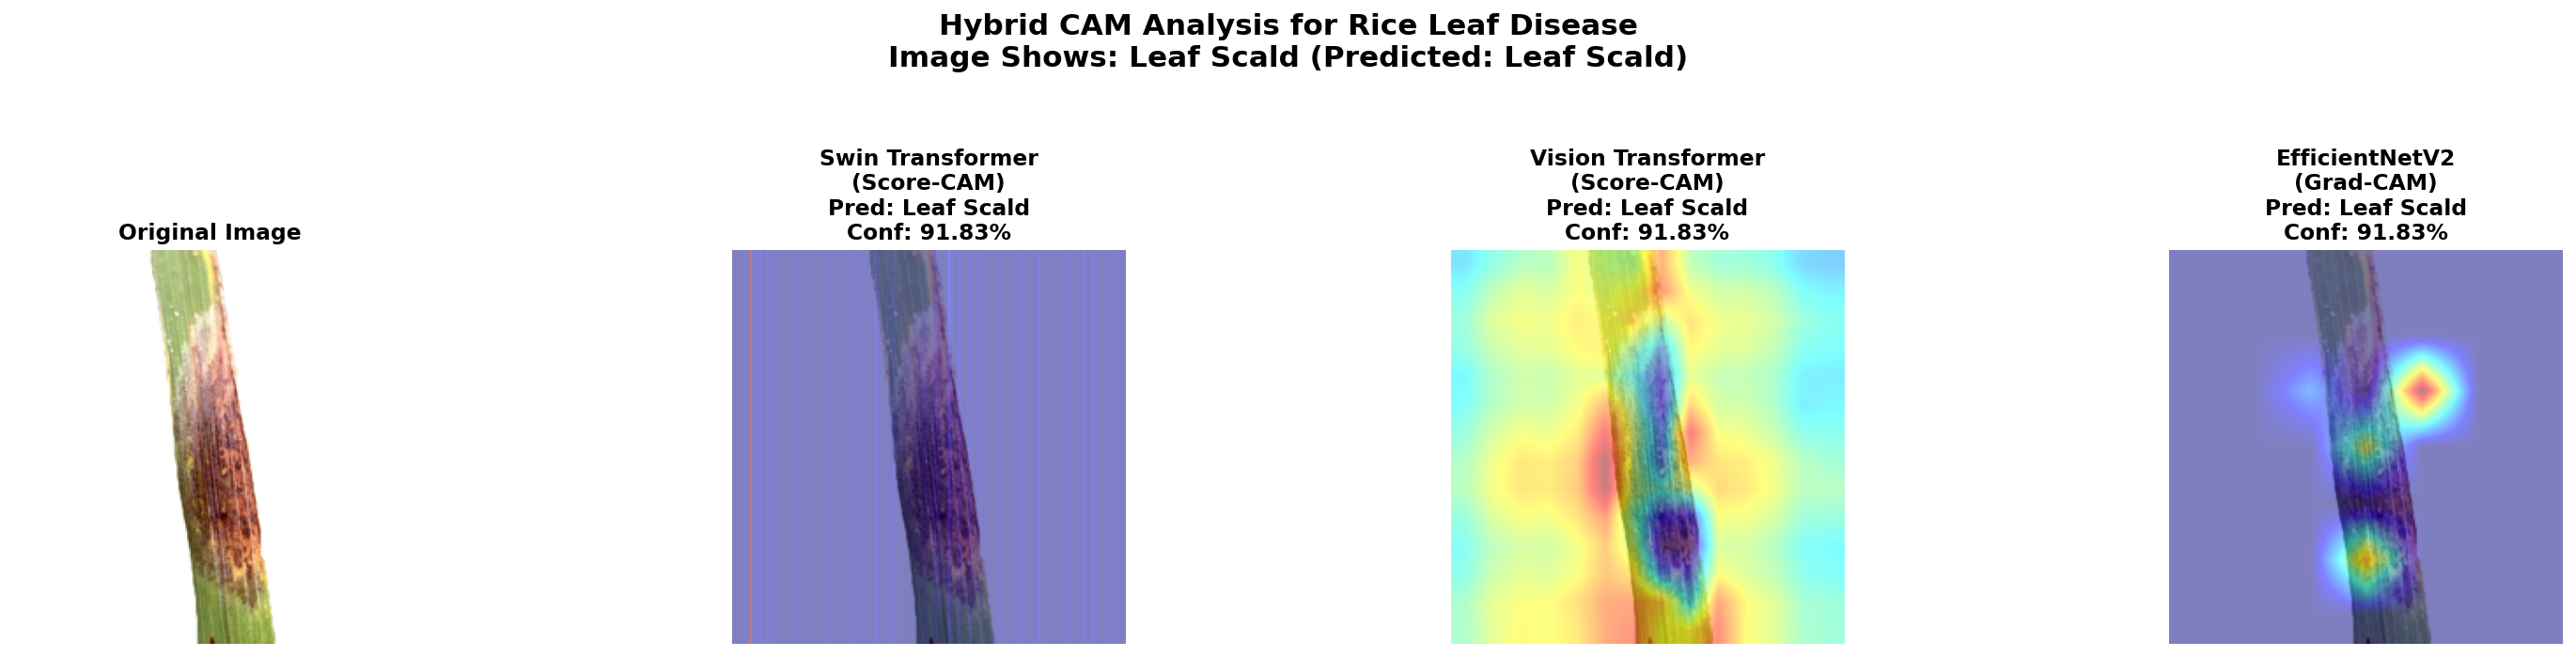

100%|██████████| 48/48 [00:14<00:00,  3.30it/s]


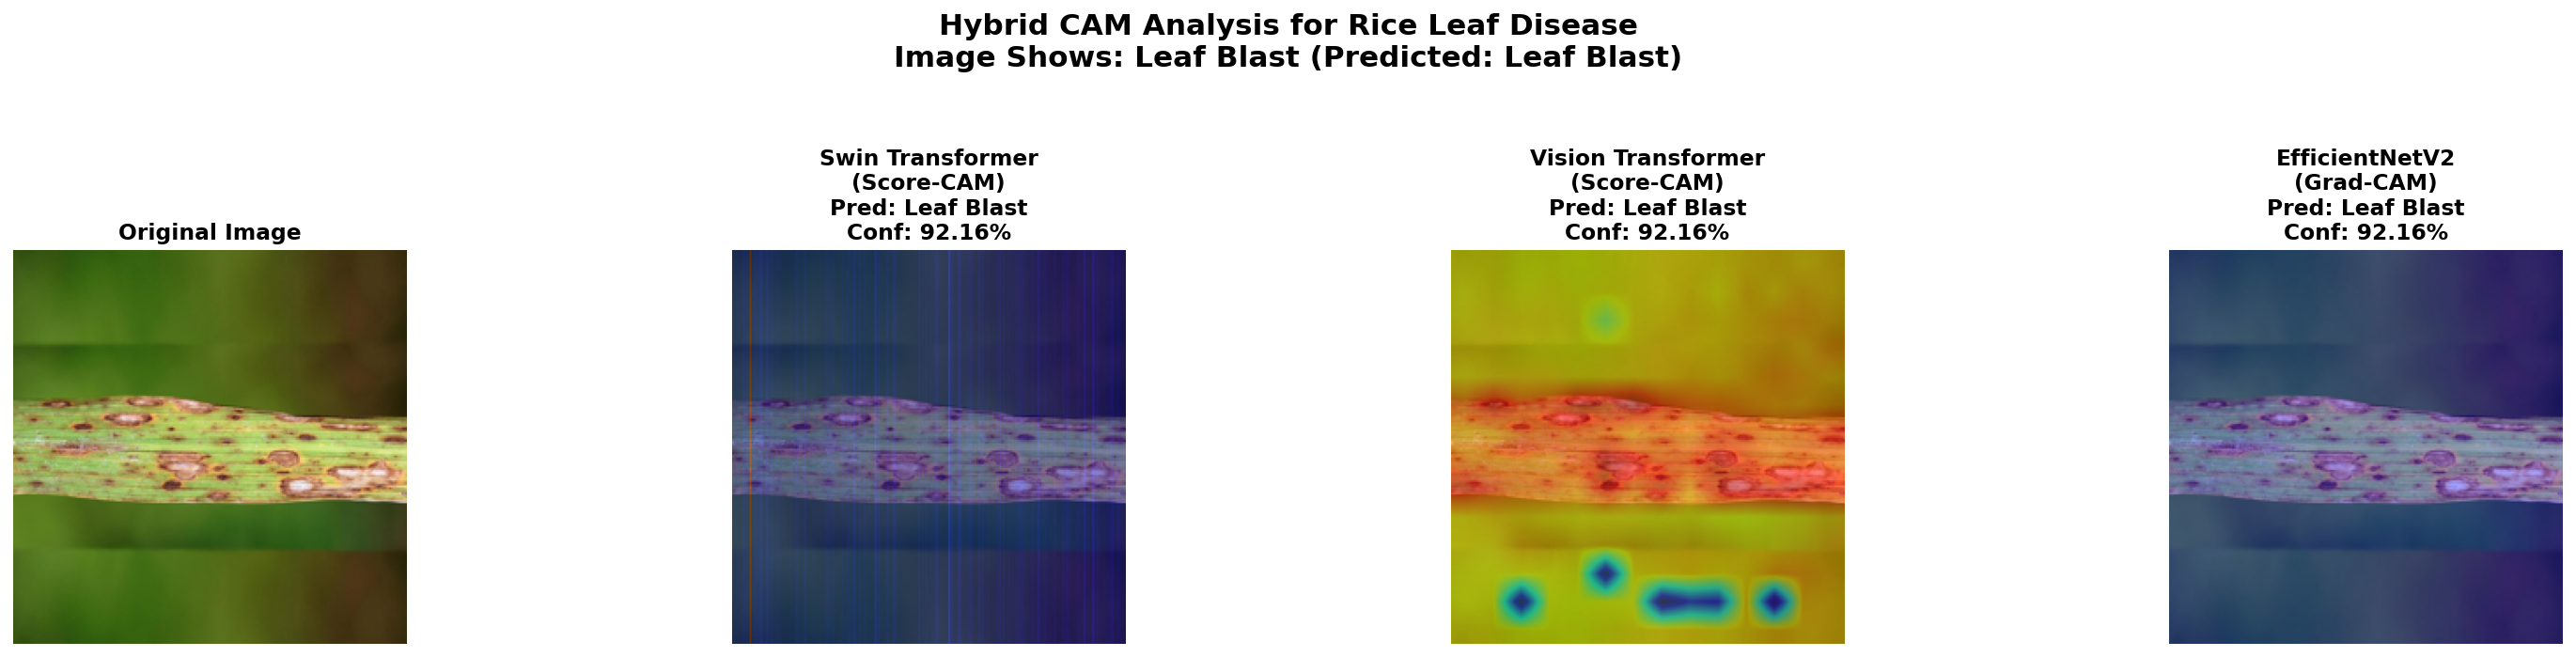

In [157]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

# --- Define a list of image paths to process ---
# >>> EDIT THESE PATHS TO YOUR OWN IMAGES <<<
image_paths = [
    "/content/Screenshot 2026-01-23 234242.png", # User's provided screenshot
    "/content/drive/MyDrive/Project-1/image/narrow_brown.jpg",
    "/content/drive/MyDrive/Project-1/image/leaf_scald.jpg",
    "/content/drive/MyDrive/Project-1/image/leaf_blast.jpg"
]
# >>> EDIT THESE LABELS TO MATCH YOUR IMAGE DESCRIPTIONS <<<
image_labels = [
    "User Screenshot", # Label for the screenshot
    "Narrow Brown Spot",
    "Leaf Scald",
    "Leaf Blast"
]

def norm(cam):
    return (cam - cam.min()) / (cam.max() - cam.min() + 1e-8)

# --- Iterate through each image and generate/plot CAMs ---
for idx, img_path in enumerate(image_paths):
    try:
        img_pil = Image.open(img_path).convert("RGB")
        input_tensor = dm.val_tfms(img_pil).unsqueeze(0).to(device)

        # prediction
        with torch.no_grad():
            logits = model(input_tensor)
            pred_idx = logits.argmax(dim=1).item()
            confidence = torch.softmax(logits, dim=1)[0, pred_idx].item()
        pred_class_name = dm.train_ds.classes[pred_idx] # Get class name here

        targets = [ClassifierOutputTarget(pred_idx)]

        # CAMs
        cam_swin = swin_cam(input_tensor, targets)[0]
        cam_vit  = vit_cam(input_tensor, targets)[0]
        cam_eff  = eff_cam(input_tensor, targets)[0]

        cam_swin_norm = norm(cam_swin)
        cam_vit_norm  = norm(cam_vit)
        cam_eff_norm  = norm(cam_eff)

        img_np = np.array(img_pil.resize((224, 224))) / 255.0

        vis_swin = show_cam_on_image(img_np, cam_swin_norm, use_rgb=True)
        vis_vit  = show_cam_on_image(img_np, cam_vit_norm, use_rgb=True)
        vis_eff  = show_cam_on_image(img_np, cam_eff_norm, use_rgb=True)

        # --- Plot for the current image ---
        fig, axes = plt.subplots(1, 4, figsize=(22, 5), dpi=140)

        axes[0].imshow(img_np)
        axes[0].set_title("Original Image", fontsize=12, fontweight='bold')
        axes[0].axis("off")

        # Function to add arrow and title to CAM plots (modified to remove arrow)
        def add_cam_details(ax, vis_cam, cam_norm, title_text, pred_class_name, confidence):
            ax.imshow(vis_cam)
            # Find hotspot on the normalized CAM
            # max_y, max_x = np.unravel_index(np.argmax(cam_norm), cam_norm.shape)

            # # Add arrow pointing to the hottest spot (removed as per user request)
            # ax.annotate(
            #     "",
            #     xy=(max_x, max_y),               # where arrow points TO
            #     xytext=(max_x + 60, max_y - 60), # where arrow starts FROM (tail)
            #     arrowprops=dict(
            #         facecolor='red',
            #         edgecolor='darkred',
            #         width=4,
            #         headwidth=14,
            #         headlength=18,
            #         shrink=0.08,
            #         alpha=0.9,
            #         linewidth=1.5,
            #         zorder=10
            #     )
            # )
            # # Add small circle at the exact hotspot (removed as per user request)
            # ax.plot(max_x, max_y, marker='o', markersize=14,
            #         color='red', markeredgecolor='white', markeredgewidth=2.5, zorder=11)

            ax.set_title(f"{title_text}\nPred: {pred_class_name.replace('_', ' ').title()}\nConf: {confidence:.2%}",
                         fontsize=12, fontweight='bold')
            ax.axis("off")

        add_cam_details(axes[1], vis_swin, cam_swin_norm, "Swin Transformer\n(Score-CAM)", pred_class_name, confidence)
        add_cam_details(axes[2], vis_vit, cam_vit_norm, "Vision Transformer\n(Score-CAM)", pred_class_name, confidence)
        add_cam_details(axes[3], vis_eff, cam_eff_norm, "EfficientNetV2\n(Grad-CAM)", pred_class_name, confidence)


        fig.suptitle(
            f"Hybrid CAM Analysis for Rice Leaf Disease\nImage Shows: {image_labels[idx]} (Predicted: {pred_class_name.replace('_', ' ').title()})",
            fontsize=16,
            fontweight="bold",
            y=1.02 # Adjust vertical position of main title
        )

        plt.tight_layout(rect=[0, 0.03, 1, 0.95]) # Adjust rect to prevent suptitle overlap
        plt.show()
    except FileNotFoundError:
        print(f"Error: Image not found at path: {img_path}. Please check the path and try again.")
    except Exception as e:
        print(f"An unexpected error occurred while processing {img_path}: {e}")
        import traceback
        traceback.print_exc()
